In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns


In [2]:
df = pd.read_csv('flights.csv')
df.info()

/tmp/ipykernel_56008/493874064.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flights.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [3]:
def prep_data(df):
    delay = []
    for row in df['ARRIVAL_DELAY']:
        if row > 60:
            delay.append(3)
        elif row > 30:
            delay.append(2)
        elif row > 15:
            delay.append(1)
        else:
            delay.append(0)
    df['delay'] = delay
    df=df.drop(['YEAR','FLIGHT_NUMBER','AIRLINE','DISTANCE','TAIL_NUMBER','TAXI_OUT','SCHEDULED_TIME','DEPARTURE_TIME','WHEELS_OFF','ELAPSED_TIME','AIR_TIME','WHEELS_ON','DAY_OF_WEEK','TAXI_IN','CANCELLATION_REASON','ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', "CANCELLED"], axis=1)
    df.dropna(inplace = True)
    
    return df
    

In [4]:
df = prep_data(df)

In [5]:
df.value_counts('delay')

delay
1    390801
3    319092
2    313605
0     39941
Name: count, dtype: int64

In [6]:
# Import necessary libraries for data splitting, scaling, and classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extracting features and target variables from the dataset
X = df.iloc[:, :-1].values  # Features (all columns except the last)
Y = df.iloc[:, -1].values   # Target variable (the last column)

# Splitting the data into training and testing sets (70% train, 30% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Standardizing the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, mean_absolute_error, mean_squared_error, r2_score

# List of classifiers to evaluate
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(probability=True)  # SVC with probability estimates
}

# Initialize an empty list to store the results
results_list = []

# Loop over each classifier
for model_name, model in classifiers.items():
    print(f"Training model: {model_name}")

    # Train the classifier
    model.fit(X_train_scaled, Y_train)

    # Predict the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate regression metrics
    mae = mean_absolute_error(Y_test, y_pred)
    mse = mean_squared_error(Y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, y_pred)
    rmsle = np.log(np.sqrt(mse))
    mape = np.mean(np.abs((Y_test - y_pred) / Y_test)) * 100

    # Calculate classification metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    # Calculate AUC score if applicable (for binary or multilabel)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)
        auc = roc_auc_score(Y_test, y_prob, multi_class='ovr')
    else:
        auc = None

    # Print metrics
    print(f"Accuracy of {model_name}: {round(accuracy, 3)}")
    print(f"Classification Report for {model_name}:")
    print(classification_report(Y_test, y_pred))
    if auc is not None:
        print(f"AUC Score for {model_name}: {round(auc, 3)}")

    print(f'MAE: {round(mae, 3)}')
    print(f'MSE: {round(mse, 3)}')
    print(f'RMSE: {round(rmse, 3)}')
    print(f'R2 Score: {round(r2, 6)}')
    print(f'RMSLE: {round(rmsle, 3)}')
    print(f'MAPE: {round(mape, 2)}%')

    # Adjusted R-squared calculation to account for the number of features
    adjusted_r2 = 1 - (1 - r2) * (len(Y_test) - 1) / (len(Y_test) - X_test.shape[1] - 1)
    print(f'Adjusted R2 Score: {round(adjusted_r2, 6)}')

    print('------------------------------------------------------------')

    # Append the results to the list
    results_list.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 3),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3),
        'AUC': round(auc, 3) if auc is not None else None,
        'MAE': round(mae, 3),
        'MSE': round(mse, 3),
        'RMSE': round(rmse, 3),
        'R2 Score': round(r2, 6),
        'RMSLE': round(rmsle, 3),
        'MAPE': round(mape, 2),
        'Adjusted R2 Score': round(adjusted_r2, 6)
    })

# Print the results list
print(results_list)

Training model: Decision Tree


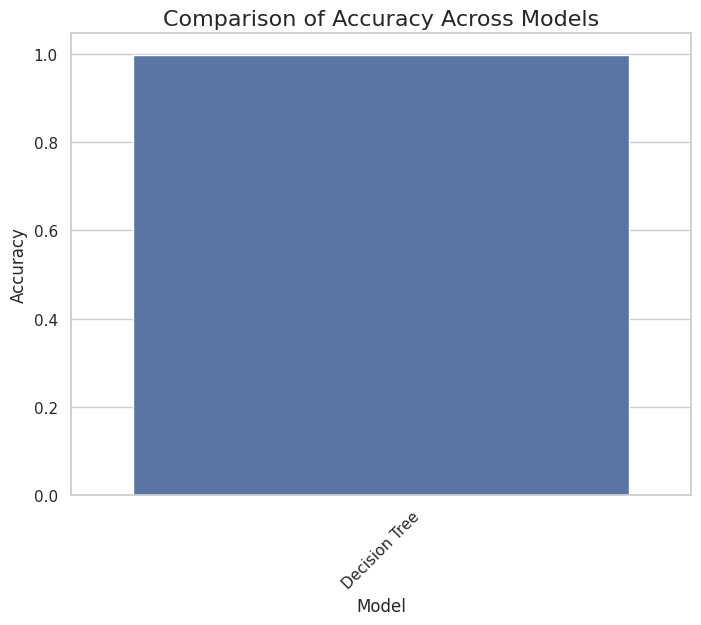

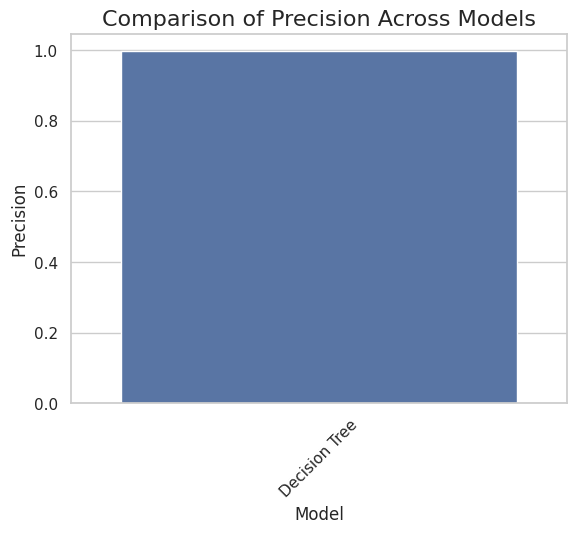

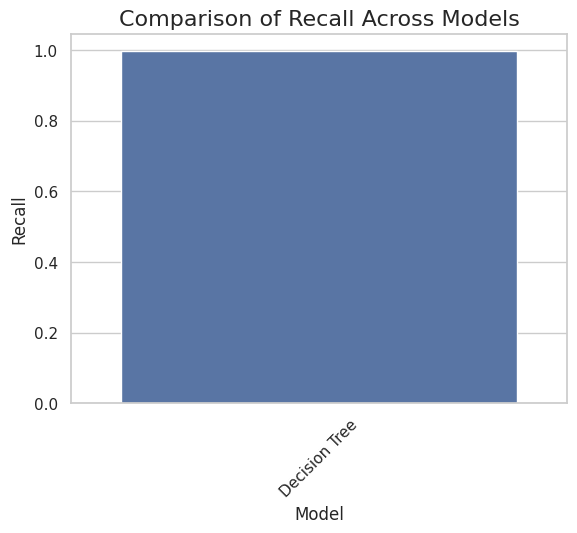

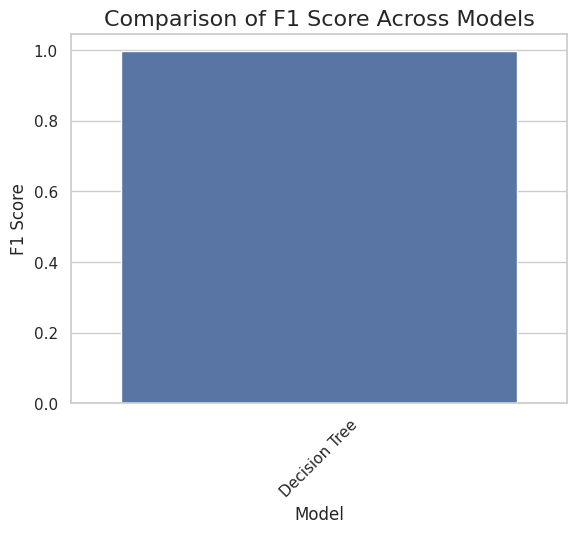

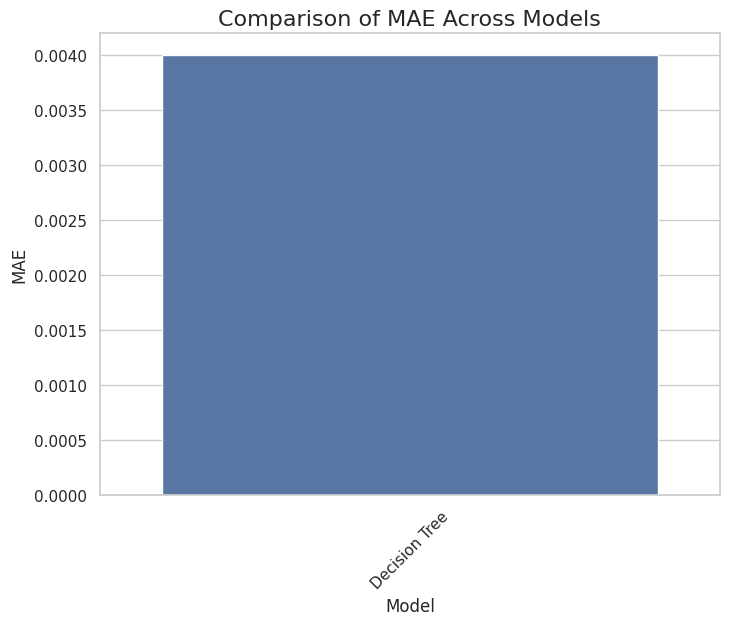

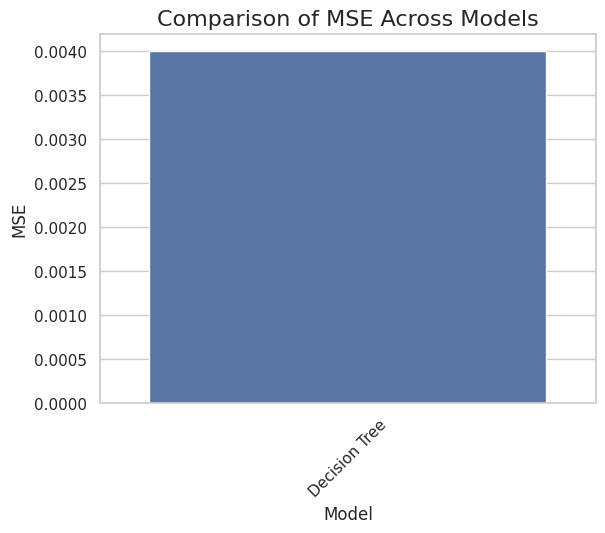

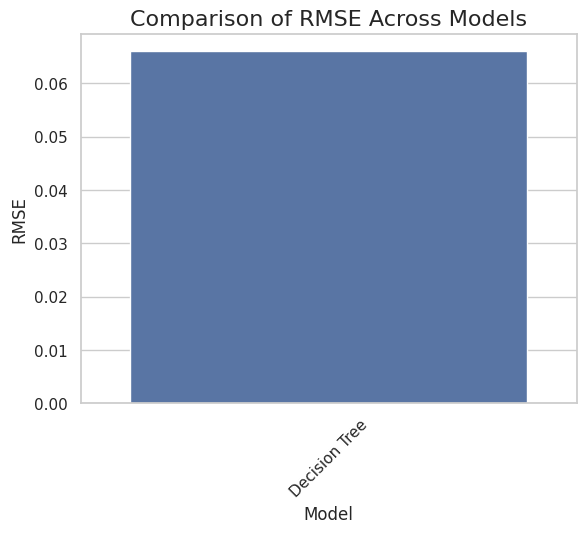

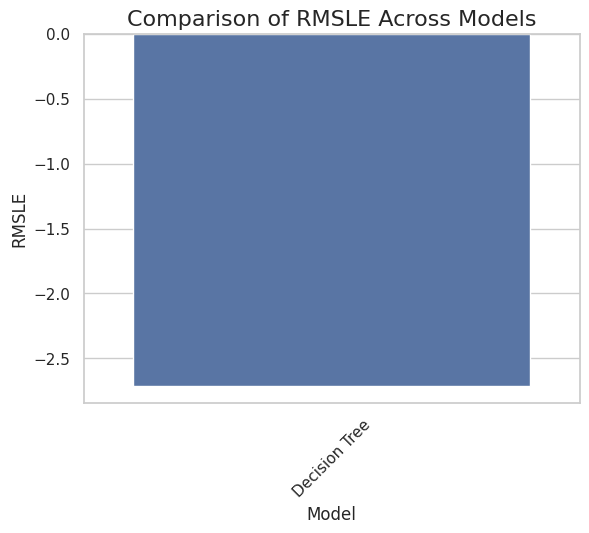

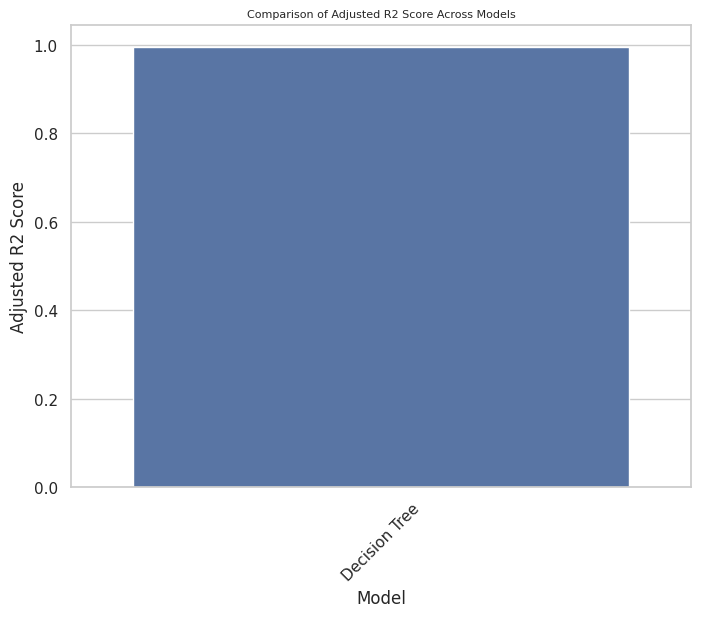

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the results_list to a DataFrame for easier plotting
results_df = pd.DataFrame(results_list)

# Set the plot style
sns.set(style="whitegrid")

# Bar plot for Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 6))
for metric in metrics:
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Comparison of {metric} Across Models', fontsize=16)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

# Bar plot for MAE, MSE, RMSE, RMSLE, and MAPE
regression_metrics = ['MAE', 'MSE', 'RMSE', 'RMSLE']

plt.figure(figsize=(8, 6))
for metric in regression_metrics:
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Comparison of {metric} Across Models', fontsize=16)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()


# Bar plot for Adjusted R-squared
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Adjusted R2 Score', data=results_df)
plt.title('Comparison of Adjusted R2 Score Across Models', fontsize=8)
plt.ylabel('Adjusted R2 Score')
plt.xticks(rotation=45)
plt.show()


Visualizing predictions for Decision Tree


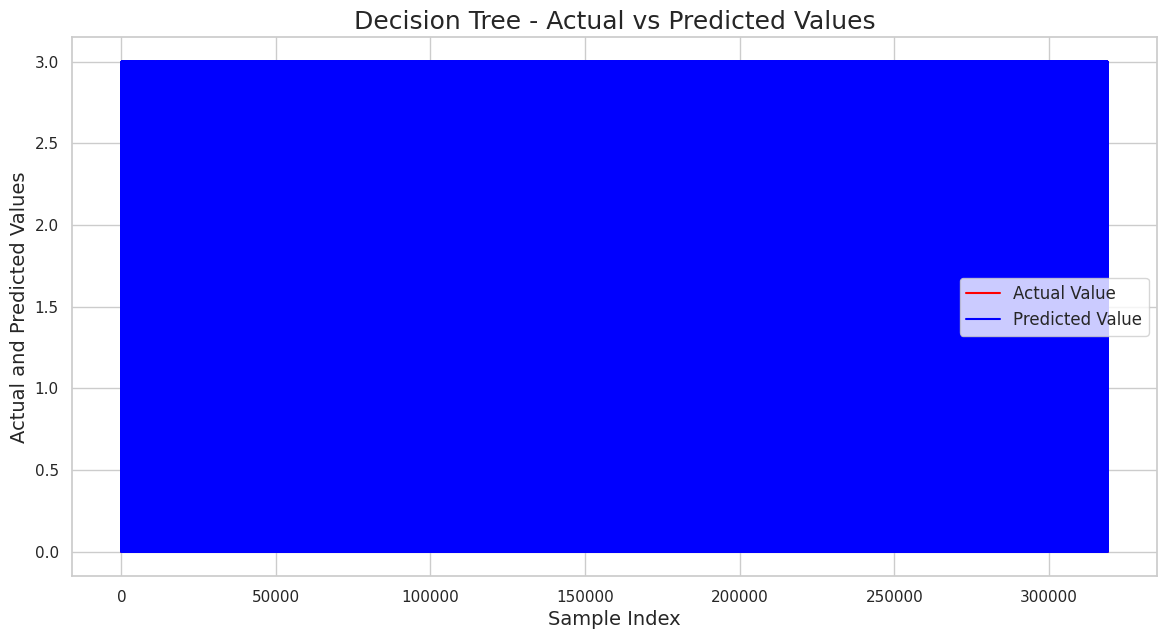

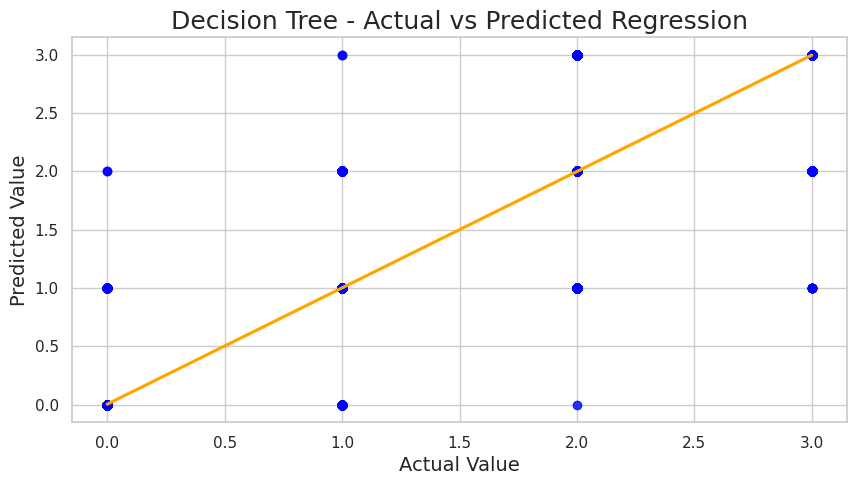

/tmp/ipykernel_56008/3153503814.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(output_df['Actual_Value'], label='Actual Value', color='red', shade=True)
/tmp/ipykernel_56008/3153503814.py:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(output_df['Predicted_Value'], label='Predicted Value', color='blue', shade=True)


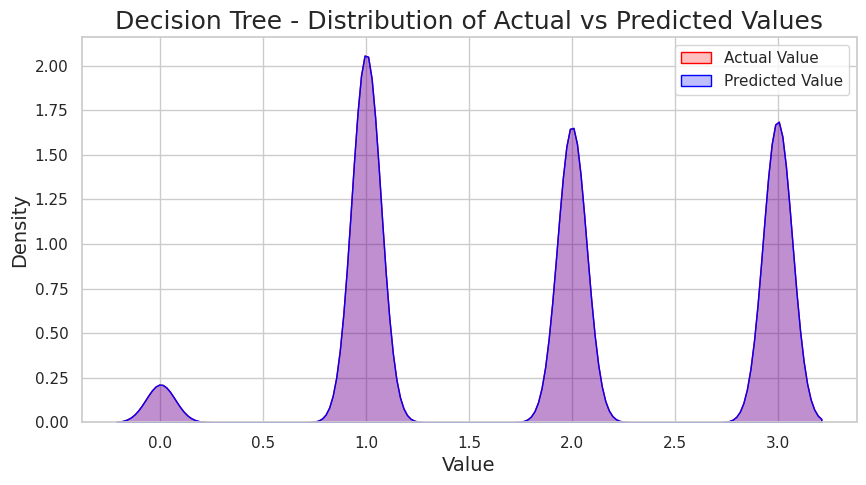

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop over each classifier for predictions and visualizations
for model_name, model in classifiers.items():
    # Train the classifier
    model.fit(X_train_scaled, Y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Creating a DataFrame to store actual and predicted values side by side
    output_df = pd.DataFrame({'Actual_Value': Y_test, 'Predicted_Value': y_pred})

    # Add an index column for plotting against the sample index
    output_df['Index'] = output_df.index
    
    # Visualize predictions for each model
    print(f'Visualizing predictions for {model_name}')
    
    # Distribution plot of Actual vs Predicted values to visualize distribution
    plt.figure(figsize=(10, 5))
    sns.kdeplot(output_df['Actual_Value'], label='Actual Value', color='red', shade=True)
    sns.kdeplot(output_df['Predicted_Value'], label='Predicted Value', color='blue', shade=True)
    plt.title(f'{model_name} - Distribution of Actual vs Predicted Values', fontsize=18)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend()
    plt.show()
